*Prelude*

In the last notebook, we learned about the generator function. We saw how it is different from a regular python function and prserves state between calls. We wrote a generator to execute a forever-while loop in an interrupted fashion using ```yield``` statement. This illustrated concurrency. 

Here we will apply the concepts to simulate a one-step process in Simpy.

## Process Description

![Dietician](Assets/Dietician.png)

Simulate a process of dietary consultation. People visit the clinic and see the consultant.

1. **Entity**: People arriving for dietary consultation
2. **Generator**: Generate arrivals for dietary consultation 
3. **Inter-Arrrival Time**: An exponential distribution sampled for patient arrivals  
4. **Activity**: Consultation with dietician
5. **Activity Time**: An exponential distribution sampled for consultation time
6. **Resources**: Dietician (1)
7. **Queues**: People waiting for consultation 
8. **Sink**: Exit after consultation

Based on: https://youtu.be/jXDjrWKcu6w

## Import packages

Aside from **simpy**, we need **random** to sample from random distributions.

In [13]:
import simpy
import random
import configuration

## Generate Arrivals

Define the generator for arrivals. This puts patients in the queue for consultation.

**Args**:
- env (Simpy environment) required
- mean_IAT (int) mean Inter-Arrival Time for generating arrivals
- mean_CT (int) mean consultation time
- dietician (Simpy resource) resource

**Notes**:
- Has a forever-while loop in which it:
	- Creates a patient ID and sends the patient onward on their journey, invoking the function that generates consultations with the patient's ID.
	- Has one ```yield``` statement to timeout for sampled Inter-Arrival Time, after which it increments patient ID. The ```yield``` with timeout will await the action (i.e. completion of timer), freezing until then and next resuming where it left off.


In [14]:
def generate_patient(env, mean_IAT, mean_CT, dietician):
    token_number = 0;

    # run indefintely
    while(True):
        # Send an arrival onward
        Consultation = generate_consultation(env, mean_CT, dietician, token_number)
        env.process(Consultation) 

        # Wait for new arrival
        deltaIAT = random.expovariate(1.0 / mean_IAT)
        yield env.timeout(deltaIAT)

        # Generate new arrival
        token_number += 1

### Generate Consultations

Define the generator for consulation.

**Args**:
- env (Simpy environment) required
- mean_CT (int) mean consultation time
- dietician (Simpy resource)
- token_number (int) patient ID from the function that generates arrivals

**Notes**:
- Has a with statement for a resource with which to timeout for sampled processing time. Will timeout until resource (nurse) is available
- Notes timestamps at: entered queue for resource (nurse), left queue, exited process.  

In [15]:
def generate_consultation(env, mean_CT, dietician, token_number):
    time_arrived = env.now
    print("Patient {} entered the queue at {:.2f}".format(token_number, time_arrived))

    with dietician.request() as req:
        # Wait until the dietician is available
        yield req

        time_consultation_started = env.now
        deltaQueued = time_consultation_started - time_arrived

        deltaCT = random.expovariate(1.0 / mean_CT)
        print("Patient {} entered consultation at {:.2f}, having waited {:.2f}".format(token_number, time_arrived, deltaQueued))
        yield env.timeout(deltaCT)


### Set Up Simulation

Define simulation variables as follows:
- Create an instance of env
- Initialize resources
- Define key parameters (for distributions)

In [16]:
# Set up the simulation environment
env = simpy.Environment()

# Set up the resources
dietician = simpy.Resource(env, 1)

# Configure simulation parameters
mean_IAT = 5 
mean_CT = 6



### Run Simulation

Run the simulation as follows:
- Register the function that generates arrivals with the environment
- Run simulation

In [17]:
# Make it so!
env.process(generate_patient(env, mean_IAT, mean_CT, dietician))
env.run(until=540)

Patient 0 entered the queue at 0.00
Patient 0 entered consultation at 0.00, having waited 0.00
Patient 1 entered the queue at 6.97
Patient 1 entered consultation at 6.97, having waited 3.38
Patient 2 entered the queue at 16.38
Patient 2 entered consultation at 16.38, having waited 0.00
Patient 3 entered the queue at 18.77
Patient 3 entered consultation at 18.77, having waited 0.00
Patient 4 entered the queue at 30.59
Patient 4 entered consultation at 30.59, having waited 0.00
Patient 5 entered the queue at 34.78
Patient 5 entered consultation at 34.78, having waited 0.00
Patient 6 entered the queue at 39.32
Patient 6 entered consultation at 39.32, having waited 0.09
Patient 7 entered the queue at 44.30
Patient 8 entered the queue at 46.97
Patient 9 entered the queue at 49.70
Patient 7 entered consultation at 44.30, having waited 12.20
Patient 10 entered the queue at 57.46
Patient 11 entered the queue at 59.65
Patient 8 entered consultation at 46.97, having waited 13.16
Patient 12 enter

*Epilog*

We have used Simpy to simulate a one-step process with two generator functions. The 1st has a *forever-while loop* that generates arrivals and sends them on their way. This forever-while loop *is* the program's main (and only) thread. It runs in an interrupted fashion to allow concurrency. We get the pereception of conucrrent actions because in process simulation, only the start and finish of an operation are of material consequence and the program can execute tasks queued in the event loop in the interval. Thus, the forever-while loop in the 1st generator function directs the script.

The 2nd generator function is where the action is. The ```with``` statement requests a resource and waits for it. Once available, it samples a processing time and then waits again, the exits. The 1st generator function spawns a new instance of the 2nd generator function for each patient to send her on her merry way.

*What if* we have multiple steps in a process? Let's us see how to handle that in the next notebook.

## Part B: Scenario Planning

So far, we have simulated the consultation process. To apply this approach in sceario-planning, we will need to stash the results for presentation. We want to compare scenarios, ideally with multiple runs to have representative data for each. In this section, we will save simulation results and generate plots, using Pandas for data aggregation and Matplotlib for plotting. 

In [18]:
import simpy
import random
import configuration
from matplotlib import pyplot as plt

Rename and make no changes to the function to generate arrivals.

In [19]:
def generate_patient_mem(env, mean_IAT, mean_CT, dietician):
    token_number = 0;

    # run indefintely
    while(True):
        # Send an arrival onward
        Consultation = generate_consultation_mem(env, mean_CT, dietician, token_number)
        env.process(Consultation) 

        # Generate new arrival
        deltaIAT = random.expovariate(1.0 / mean_IAT)
        yield env.timeout(deltaIAT)

        token_number += 1

Rename and update the function to generate consultations to include global variables (lists) to persist data - timestamps and intervals. We want to know how long patients wait in queue. So we will use two global variables as follows:
- ```arrived``` (list) time of arrival for consultation
- ```queued``` (list) length of time in queue waiting for consultation

In [20]:
def generate_consultation_mem(env, mean_CT, dietician, token_number):
    global arrived
    global queued
    
    time_arrived = env.now
    print("Patient {} entered the queue at {:.2f}".format(token_number, time_arrived))

    with dietician.request() as req:
        # Wait until the dietician is available
        yield req

        time_consultation_started = env.now
        deltaQueued = time_consultation_started - time_arrived

        arrived.append(time_arrived)
        queued.append(deltaQueued)

        deltaCT = random.expovariate(1.0 / mean_CT)
        print("Patient {} entered consultation at {:.2f}, having waited {:.2f}".format(token_number, time_arrived, deltaQueued))
        yield env.timeout(deltaCT)

### Set up and run

Define the global variables and plot using matplotlib.

In [21]:
# Set up the simulation environment
env = simpy.Environment()

# Set up the resources
dietician = simpy.Resource(env, 1)

# Configure simulation parameters
mean_IAT = 5 
mean_CT = 6

# Set up the global variables
arrived = []
queued = []

# Make it so!
env.process(generate_patient_mem(env, mean_IAT, mean_CT, dietician))
env.run(until=540)

Patient 0 entered the queue at 0.00
Patient 0 entered consultation at 0.00, having waited 0.00
Patient 1 entered the queue at 13.52
Patient 1 entered consultation at 13.52, having waited 0.00
Patient 2 entered the queue at 17.31
Patient 2 entered consultation at 17.31, having waited 0.00
Patient 3 entered the queue at 44.62
Patient 3 entered consultation at 44.62, having waited 0.00
Patient 4 entered the queue at 50.61
Patient 4 entered consultation at 50.61, having waited 0.00
Patient 5 entered the queue at 56.72
Patient 5 entered consultation at 56.72, having waited 0.00
Patient 6 entered the queue at 61.02
Patient 6 entered consultation at 61.02, having waited 0.00
Patient 7 entered the queue at 67.30
Patient 7 entered consultation at 67.30, having waited 0.93
Patient 8 entered the queue at 81.89
Patient 8 entered consultation at 81.89, having waited 0.00
Patient 9 entered the queue at 82.91
Patient 9 entered consultation at 82.91, having waited 6.89
Patient 10 entered the queue at 

In [22]:
gantt = zip(arrived, queued)
g50 = list(gantt)[0:50]

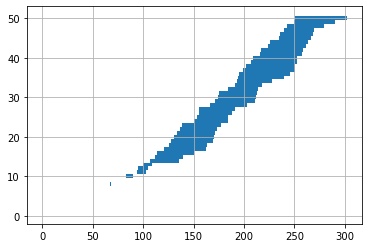

In [23]:
fig, gnt = plt.subplots()
gnt.grid(True)

idx_y = 0.5
for i in g50:
    gnt.broken_barh([i], (idx_y,1.0))
    idx_y += 1


## Homework Assignment

1. Enhance the plot, making at least two enhancements to clarify the message. Explain the enhancements and how they improve the message.
2. Notice the ```zip``` function returns a generator. We have forced it to a list. Doing so means we have access to the entire contents at once, whereas a generator only gives the next item upon request. But list is less efficient because entire contents are loaded into memory whereas we may only want to work with one item from the list at a time. Rewrite the plotting function with the generator. 

## Part C: Object Oriented Programming

So far we have simuulated a simple process. As process complexity increases and it has multiple steps, possibly sharing resources, with outages and other scenarios baked in the process characterization, we need to organize code better. We do this with Object Oriented Programming (OOP) where we divide responsibilities among classes. A class bundles data and methods into a package with logically coherent behavior. 